In [1]:
%run ./resources/library.py

In [2]:
# Run this cell if not using JupyterLab
style_notebook()

# Notebook 3 - Advanced: Analyzing the John Snow Cholera Outbreak Using OpenStreetMaps and Networkx - Part 1

## Review of Notebooks 1 and 2 - Basic Notebooks

**Note:** This is an advanced notebook and optional for Tier 1.

Picking up from Notebook 2, from the Cholera Case Study, Basic Notebooks, we calculated the mean center of all death points on the map. The result is shown on Figure 1 below.

<img src='images/choleramap-level1-1.png'/>

**Figure 1.** Mean center of all death points in relation to location of deaths and pumps.

## Learning Objectives

By the end of this notebook, you should be able to:
1. Describe what Dr. John snow was thinking when he created the second map of the catchment area for the Broad Street pump.
2. Explain why working with street network data using the Python package `osmnx` helps visualize Dr. John Snow's catchment area map.
3. Explain how the translation of data into graph and network structure (nodes and edges) can help solve problems in public health.

## Transportation and Water Supply in 18th Century London

London, in the 18th Century was practically a walking city. Pedestrians walked on narrow streets with animals, different forms of horse-drawn carriages, and with various carts and wagons used to transport goods. In that same time period, running water and toilets did not exist. People used town wells and communal pumps to get drinking water and dumped their untreated sewage either into the Thames River or in cesspools (open pits).

## Catchment area for the Broad Street Pump

Dr. John Snow suspected that many of the cases he found used the pump at Broad Street. He drew a second map that illustrated the catchment area for the Broad Street pump.

![](./images/voronoi-snow.jpg)

**Figure 2.** Second map drawn by Dr. John Snow showing catchment area of the Broad Street Pump

The following diagram is a more modern representation of Dr. John Snow's second map above. Shown enclosed in the black polygon is the catchment area for the Broad Street pump. An adjustment to the polygon (gray line) was made to accommodate the catchment area for the greyed out pump.

![](./images/7-Figure4-1.png)

**Figure 3.** Modern version of Figure 2 above showing correction (extended area beyong the gray line) [Shiode, 2012]

The following diagram is a map of the catchment areas of the Soho pumps.
The pump catchment areas are represented by the colors of the streets between the pumps.![](./images/6-Figure3-1.png)

**Figure 4.** Catchment areas from Figure 3 in color [Shiode, 2012]

## Using OpenStreetMap and NetworkX (OSMNx)

In this notebook, we will produce a map visualization that illustrates the catchment area for the Broad Street pump but from a walkability perspective. We will use two new packages, `osmnx` (OpenStreetMap and Networkx) and `networkx`. 

**OpenStreetMap-Networkx (OSMnx)**: A Python package for downloading administrative boundary shapes and street networks from OpenStreetMap, and allows you to easily construct, project, visualize, and analyze complex street networks in Python with NetworkX (see References). 

**Networkx**: A Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks (See References).

Using the graph representation of the street networks of Soho District, we will calculate the mean walkable distance of all death points to each of the pumps (See Figure 5 for an illustration of point-to-point calculations). 

![](./images/choleramap-level1-2.png)

**Figure 5.** The computation approach to calculating mean distance values between each pump and all death coordinates on the Soho district map.

We will carry out the following steps:

**Notebook 3:**
1. Read the street network graph of Soho district using OSMnx. 
2. Plot the street network graph on a `folium` map.

**Notebook 4:**
1. Prepare the original data sets from Notebook 1.

2. To represent the pumps and deaths points (coordinates) from the Notebook 1 in OSMnx graph format, we have to find the nearest OSMnx nodes to those points. We will add new columns to the pumps and deaths dataframes to accomodate new information coming from OSMnx. We will also store the short distances between original points to the nearest OSMnx points and store it in the respective dataframes.

3. To calculate mean distances from deaths points to pumps points we will create a double loop through records of both pumps and deaths dataframes so we can do pairwise distance calculations between each pumps point and each deaths point. We will add the short distances from #1 to the pump point to death point distance and store this in a new dataframe called `routes_df`.

4. We will then create the map representation pump-to-death-points mean distances using `folium` and superimpose this from the death dataframe markers generated in Notebook 1.

5. We will illustrate the degrees of  walkability using an isochrone map.

First, let's `import osmnx`, provide some configuration parameters and print its version. The default setting for `osmnx` is to show debugging information. You can turn this off by setting everything to `False` below.

In [3]:
import osmnx as ox

# some configuration parameters for osmnx
# set log to True to for debugging
ox.config(log_file=True, log_console=True, use_cache=True)

ox.__version__

'0.10'

## Step 1. Read street network information from OSMnx

### Reading Graph, `G`, from `SOHO_COORDINATES`

The <font color='red'>`ox.graph_from_point()`</font> dot function below loads a street network graph into variable `G`. The `ox.plot_graph()` for function plots a static street network graph using graph `G`.

> **Note:** The code below might take some time to execute (several seconds). We will use the `%%time` magic to time the code execution.

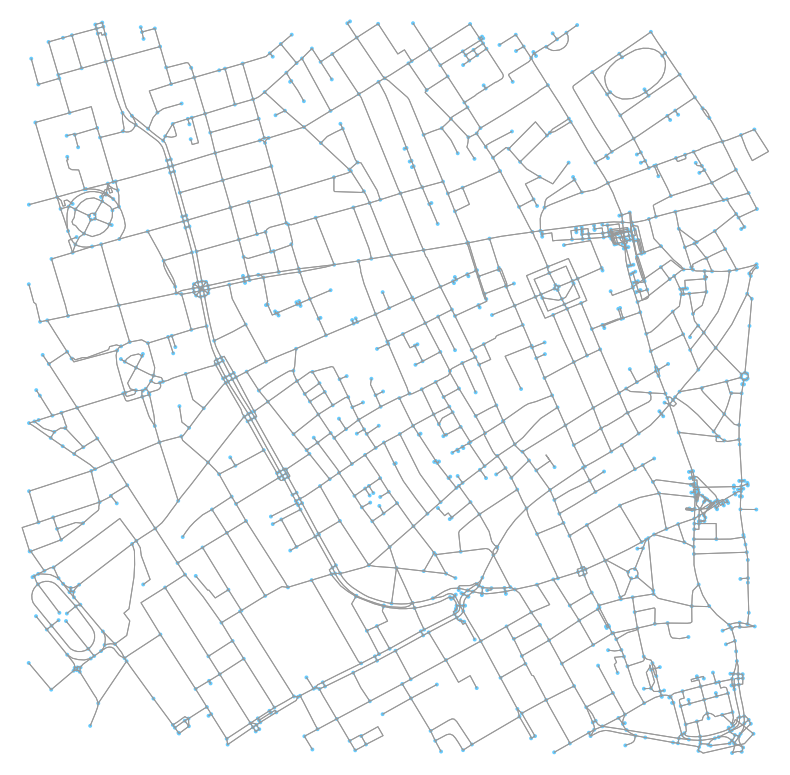

In [4]:
SOHO_COORDINATES = (51.513578, -0.136722)



Typing `G` by itself exposes the object type of `G`  a `networkx.classes.multidigraph.MultiDiGraph`. 

In [5]:
G

We used the `walk`-type street network. There are several OSMnx network types:

1. `drive` - get drivable public streets (but not service roads)
2. `drive_service` - get drivable streets, including service roads
3. <font color='red'>`walk`</font> - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
4. `bike` - get all streets and paths that cyclists can use
5. `all` - download all non-private OSM streets and paths
6. `all_private` - download all OSM streets and paths, including private-access ones

Because we are after walkability to the pump, we will use "walk" as our network type.

Let's print some graph statistics using a Python 3 built-in pretty printing function, `pprint`.

In [6]:
from pprint import pprint

basic_stats = ox.basic_stats(G)
pprint(basic_stats)

{'circuity_avg': 1.0347017146317128,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 33.94615589743584,
 'edge_length_total': 132390.00799999977,
 'intersection_count': 1154,
 'intersection_density_km': None,
 'k_avg': 5.615550755939525,
 'm': 3900,
 'n': 1389,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 33.946155897435894,
 'street_length_total': 66195.00399999999,
 'street_segments_count': 1950,
 'streets_per_node_avg': 2.8934485241180705,
 'streets_per_node_counts': {0: 0, 1: 235, 2: 0, 3: 854, 4: 284, 5: 10, 6: 6},
 'streets_per_node_proportion': {0: 0.0,
                                 1: 0.16918646508279336,
                                 2: 0.0,
                                 3: 0.6148308135349172,
                                 4: 0.2044636429085673,
                                 5: 0.007199424046076314,
                               

### Saving Graph, `G`, as GraphML file

OSMnx has the ability to save street network graphs as GraphML files. Let's save the graph to a GraphML file. To learn more about GraphML, click [here](http://graphml.graphdrawing.org/). The GraphML primer can be found [here](http://graphml.graphdrawing.org/primer/graphml-primer.html).

In [7]:
ox.save_graphml(G, filename='soho.graphml', folder='outputs')

> ### Notes on GraphML
> From the GraphML [web site](http://graphml.graphdrawing.org/):
>   
> `GraphML` (graph markup language) is a comprehensive and easy-to-use file format for **graphs**. A **graph** (see Figure 6 below) is made up of nodes (yellow circles) and edges (connecting lines). It consists of a language core to describe the structural properties of a graph and a flexible extension mechanism to add application-specific data.*
>   
> ![](images/simple.png)

> **Figure 6.** A simple graph with nodes and edges 

In [8]:
!ls -la outputs

total 4236
drwxr-xr-x  3 jovyan users    4096 Jul  3 20:18 .
drwxr-xr-x 10 jovyan users    4096 Jul 13 07:42 ..
-rw-r--r--  1 jovyan users   14878 Jun 27 12:16 deaths_df.pickle
-rw-r--r--  1 jovyan users   13131 Jun 27 12:16 deaths_mean_center_df.pickle
drwxr-xr-x  4 jovyan users    4096 Jun 27 12:16 graph
-rw-r--r--  1 jovyan users 2419236 Jul  3 20:18 graph.html
-rw-r--r--  1 jovyan users     715 Jun 27 12:16 mean_center_df.pickle
-rw-r--r--  1 jovyan users      10 Jun 27 12:16 poly20.cpg
-rw-r--r--  1 jovyan users      78 Jun 27 12:16 poly20.dbf
-rw-r--r--  1 jovyan users  224904 Jun 27 12:16 poly20.geojson
-rw-r--r--  1 jovyan users     143 Jun 27 12:16 poly20.prj
-rw-r--r--  1 jovyan users   68268 Jun 27 12:16 poly20.shp
-rw-r--r--  1 jovyan users     108 Jun 27 12:16 poly20.shx
-rw-r--r--  1 jovyan users    1029 Jun 27 12:16 pumps_df.pickle
-rw-r--r--  1 jovyan users   30595 Jun 27 12:16 routes2_df.pickle
-rw-r--r--  1 jovyan users   30595 Jul 13 07:35 routes400m_df.pickle
-rw-r-

## Step 2. View the street network graph, `G`, with Folium

In [9]:
from IPython.display import IFrame
import pandas as pd
import folium
import numpy as np

# let's import the folium plugins
from folium import plugins

In [10]:
pd.__version__, folium.__version__

('0.24.2', '0.10.0')

### Create `folium` map, `map1`, using `osmnx`, then overlay graph, `G`

`osmnx` allows us to create a `folium` map from graph `G`. This enables us to combine this graph with other data (deaths and pumps). Let's reuse the same map name from Notebooks 1 and 2, `map1`.

In [11]:
map1 = ox.plot_graph_folium(G, \
                 edge_width=2, \
                 tiles='cartodbpositron', \
                 edge_color='gray', \
                 popup_attribute=None,\
                 zoom = 18, \
                 edge_opacity=0.5)

### Load pumps and deaths data points

In [12]:
deaths_mean_center_df = pd.read_pickle('outputs/deaths_mean_center_df.pickle')
pumps_df = pd.read_pickle('outputs/pumps_df.pickle')

Note that we used the version of `deaths_df` with values from mean center calculations. 

In [13]:
deaths_mean_center_df.dtypes

FID              int64
DEATHS           int64
LON            float64
LAT            float64
product_LAT    float64
product_LON    float64
dtype: object

### Plot pumps and data points 

We copy (re-use) some of the Python code we wrote in Notebooks 1 and 2. The code below should look familiar to you. The main difference is we changed the `folium` map name from `map1` to `graph_map`.

In [14]:
deaths_mean_center_df.head()

,FID,DEATHS,LON,LAT,product_LAT,product_LON
0,0,3,-0.137930,51.513418,154.540254,-0.413790
1,1,2,-0.137883,51.513361,103.026722,-0.275766
2,2,1,-0.137853,51.513317,51.513317,-0.137853
3,3,1,-0.137812,51.513262,51.513262,-0.137812
4,4,4,-0.137767,51.513204,206.052816,-0.551068


In [15]:
locationlist = deaths_mean_center_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_mean_center_df[["DEATHS"]].values.tolist()

for i in range(0, len(locationlist)):
    popup = folium.Popup('Location: '+'('+str(locationlist[i][0])+\
                         ', '+str(locationlist[i][1])+')'+\
                         '<br/>'+\
                        'Deaths: '+ str(radiuslist[i][0]))
    # add each location with deaths to map1
    folium.CircleMarker(
                    location=locationlist[i], \
                    radius=radiuslist[i], \
                    popup=popup, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1).add_to(map1)
    
for each in pumps_df.iterrows():
    popup = folium.Popup('Location: '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')')
    #add each water pump to map1
    folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                                color='black', \
                                weight=1,\
                                fill_opacity=1, \
                                fill_color='blue', \
                                number_of_sides=4, \
                                popup=popup, \
                                radius=10).add_to(map1)
    
# let's use the "Fullscreen" plugin
# add the button to the top right corner
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(map1)

### Add mean center point to `graph_map`

In [16]:
mean_LON = np.sum(deaths_mean_center_df['product_LON'])/np.sum(deaths_mean_center_df['DEATHS'])
mean_LAT = np.sum(deaths_mean_center_df['product_LAT'])/np.sum(deaths_mean_center_df['DEATHS'])

mean_center_POINT = (mean_LAT, mean_LON)

folium.CircleMarker(
            location=mean_center_POINT, \
            color='black', \
            weight=2, \
            fill_opacity=1, \
            fill_color="yellowgreen", \
            popup=folium.Popup('Mean Center Point: '+ \
                str(mean_center_POINT)), \
            radius=10).add_to(map1)

### Write folium map to an html file and view `graph_map` using `IFrame`

Before saving the `folium` display as an HTML file, let's check if it exists. If it exists, we will delete it.

In [17]:
%%bash
FILE=outputs/graph.html
if [ -f "$FILE" ]; then
    echo "$FILE exists"
    rm $FILE
else
    echo "$FILE does not exist"
fi

outputs/graph.html exists


You can zoom in to see the map at a higher resolution.

In [18]:
filepath = 'outputs/graph.html'
map1.save(filepath)
IFrame(filepath, width=900, height=600)

### Summary

We have explored several topics from Notebooks 1 to 3:
1. Learned about the cholera outbreak in 1854 in Soho District and the maps that Dr. John Snow created to explain his theory that cholera is not spread by bad air.
2. Used `folium` and `pandas` for basic representation of data points (pumps and deaths) in code and visualizing those data points on a folium map.
3. Used **mean center point** algorithm to determine where the centroid is of all death data points in relation to pump locations.
4. Used a powerful Python package called `osmnx` to display the street network graph of Soho District.
5. Overlay the street network graph with cholera data points on a `folium` map

In Notebooks 4 and 5, we will calculate "walkability" characteristics of the Soho district street network graph using point-to-point calculations of mean distance values. 

### Discussion questions

1. With your rudimentary knowledge of graphs, what kinds of data problems can we represent with graphs and graph structure?

## Congratulations!

You have completed Notebook 3. Please proceed to Notebook 4 to go over some more exciting applications of `osmnx`.

## References

1. Boeing, Geoff. OSMnx: Python for Street Networks. URL: https://geoffboeing.com/2016/11/osmnx-python-street-networks/
2. Networkx. URL: https://networkx.github.io/
3. Shiode S. Revisiting John Snow's map: network-based spatial demarcation of cholera area. International Journal of Geographical Information Science Volume 26, 2012 - Issue 1. URL: https://www.tandfonline.com/doi/abs/10.1080/13658816.2011.577433.

*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*